<a href="https://colab.research.google.com/github/daphnecor/intro-to-rl/blob/main/Chapter_2_multi_armed_bandits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 6)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.facecolor'] = 'white'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
'''
Helper functions
'''
def cummean(arr: np.ndarray) -> np.ndarray:
    return arr.cumsum() / np.arange(1, len(arr) + 1)

### 2.5 Tackling a Non-stationary Problem

---



> **Ex. 2.5**. (page 33) Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. 
- Use a modified version of the 10-armed testbed in which all the $q_{*}(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean 0 and standard deviation 0.01 to all the $q_{*}(a)$ on each step).
- Prepare plots like Fig. 2.2 for
    - an action-value method using sample averages, incrementally computed
    - another action-value method using a constant step-size parameter, $\alpha=0.1$
- Use $\varepsilon=0.1$ and longer runs, say of $T=10,000$ steps.

---

[`action-value algorithm`] **Sample averages**. Sample-average methods estimating action values by averaging the total amount of rewards by the number of times we have visited a state:

\begin{align}
    Q_{t+1}(a) \equiv 
    \frac{\sum_{i=1}^t R_i \cdot \mathbb{1}_{A_i=a}}
    {\sum_{i=1}^t \mathbb{1}_{A_i=a}}
\end{align}

or 

\begin{align}
    Q_{t+1}(a) \equiv Q_{t}(a) + \frac{1}{N(a)}(R - Q(a))
\end{align}

By the law of large numbers, we know that $Q_t(a) \rightarrow q^{*}(a)$ when $t \rightarrow \infty$.

$$
$$

[`action-value algorithm`] **Constant step size**. 

\begin{align}
    Q_{t+1}(a) \equiv Q_t(a) + \alpha \left( R(a)- Q_t(a) \right)
\end{align} 

#### Stationary problem

We first implement a stationary bandit problem and take the action values as follows:

\begin{align}
q_{*}(a) \sim \mathcal{N}(\boldsymbol{\mu}=\mathbf{0}, \Sigma=I) \quad \text{for all} \quad a=1, \dots, 10
\end{align}

During learning, when action $A_t$ is selected at timestep $t$, the reward $R_t$ is sampled as:

\begin{align}
R_t \sim \mathcal{N}(\mu=A_t, \sigma^2=1)
\end{align}


(see paragraph 2.3 for more info on this setting)

In [11]:
"""
Tracking a stationary problem
"""

# Always set the seed
SEED = 31337
np.random.seed(SEED)

# Number of bandits
num_bandits = 10

# Get the "true" action values
action_values = np.sort(np.random.normal(loc=0, scale=1, size=num_bandits))
print(f"action values: [{'; '.join([f'{val:.2f}' for val in action_values])}]")

# Parameters
epsilon = 0.1 
num_steps = 1000
alpha = 0.1 # None

eps_params = [0, 0.01, 0.1]

action values: [-1.62; -1.02; -0.84; -0.80; -0.54; -0.04; 0.15; 0.27; 0.67; 0.70]


In [12]:
# Initialize
q_values = np.zeros(shape=(len(eps_params), num_bandits, num_steps))
action_counts = np.zeros((len(eps_params), num_bandits))
rewards_seq = np.zeros((len(eps_params), num_steps))

for idx, eps in enumerate(eps_params):
    np.random.seed(SEED)

    for step in range(num_steps):

        # Choose an action
        if np.random.rand() < eps: # Explore
            action = np.random.choice(num_bandits)
        else: # Exploit
            action = np.random.choice(
                np.argwhere(
                    q_values[idx, :, step] == q_values[idx, :, step].max()
                ).flatten(),
                size=1
            )

        action_counts[idx, action] += 1
        
        # Obtain and store reward
        reward = np.random.normal(loc=action_values[action], scale=1)
        rewards_seq[idx, step] = reward

        step_size = 1 / action_counts[idx, action] if alpha is None else alpha

        # Update Q-value for action taken
        if step + 1 < num_steps:
            q_values[idx, action, step + 1] = q_values[idx, action, step] + step_size * (reward - q_values[idx, action, step])

            # Q-value of the other actions remain the same
            actions_not_taken = [act for act in range(num_bandits) if act != action]
            q_values[idx, actions_not_taken, step + 1] = q_values[idx, actions_not_taken, step]

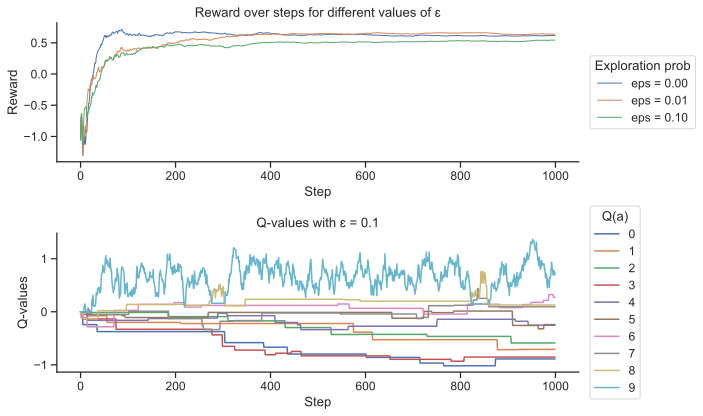

In [13]:
fig, axs = plt.subplots(2, 1)

for eps_idx, eps in enumerate(eps_params):
    axs[0].plot(
        cummean(rewards_seq[eps_idx, :]),
        linewidth=1,
        label=f'eps = {eps:.2f}',
    )
axs[0].set_title('Reward over steps for different values of ɛ')
axs[0].set_ylabel('Reward')
axs[0].set_xlabel('Step')
axs[0].legend(title='Exploration prob', loc='center left', bbox_to_anchor=(1.01, .5),)

axs[1].set_title(f'Q-values with ɛ = {eps_params[2]}')
pd.DataFrame(q_values[2, :, :]).transpose().plot(ax=axs[1])
axs[1].legend(loc='center left', bbox_to_anchor=(1.01, .5), title='Q(a)')
axs[1].set_ylabel('Q-values')
axs[1].set_xlabel('Step')
plt.tight_layout()
sns.despine()

#### Non-stationary problem

Now all the $q_{*}(a)$ start out equal and then take independent random walks:

\begin{align}
q_{*}^{0}(a) = 0.1 \text{ for all } \quad a=1, \dots, 10
\end{align}

During learning, when action $A_t$ is selected at timestep $t$, the reward $R_t$ is sampled as:

\begin{align}
R_t \sim \mathcal{N}(\mu=q_{*}^t(a), \sigma^2=1)
\end{align}

and then the q-values of all actions are updated by adding gaussian noise:

\begin{align}
q_{*}^{t+1}(a) = q_{*}^{t}(a) + \mathcal{N}(\mu=0, \sigma=0.01) \text{ for all } \quad a=1, \dots, 10
\end{align}



In [14]:
"""
Tracking a non-stationary problem
"""

# Number of bandits
num_bandits = 10

# Initalize the "true" action values
init_value = 0.1
action_values = np.full(shape=(num_bandits), fill_value=init_value)
print(f"action values: [{'; '.join([f'{val:.2f}' for val in action_values])}]")

# Parameters
epsilon = 0.1 
num_steps = 10_000
alpha = 0.1 # None

action values: [0.10; 0.10; 0.10; 0.10; 0.10; 0.10; 0.10; 0.10; 0.10; 0.10]


In [15]:
# Initialize
q_values = np.zeros(shape=(num_bandits, num_steps))
action_counts = np.zeros((num_bandits))
rewards_seq = np.zeros((num_steps))
action_values_seq = np.zeros((len(action_values), num_steps))

np.random.seed(SEED)

for step in range(num_steps):

    # Choose an action
    if np.random.rand() < eps: # Explore
        action = np.random.choice(num_bandits)
    else: # Exploit
        action = np.random.choice(
            np.argwhere(
                q_values[:, step] == q_values[:, step].max()
            ).flatten(),
            size=1
        )

    action_counts[action] += 1

    # Obtain and store reward
    reward = np.random.normal(loc=action_values[action], scale=1)
    rewards_seq[step] = reward
    action_values_seq[:, step] = action_values

    step_size = 1 / action_counts[idx, action] if alpha is None else alpha

    # Update Q-value for action taken
    if step + 1 < num_steps:
        q_values[action, step + 1] = q_values[action, step] + step_size * (reward - q_values[action, step])

        # Q-value of the other actions remain the same
        actions_not_taken = [act for act in range(num_bandits) if act != action]
        q_values[actions_not_taken, step + 1] = q_values[actions_not_taken, step]

    # Update action values
    action_values += np.random.normal(loc=0, scale=0.01, size=num_bandits)

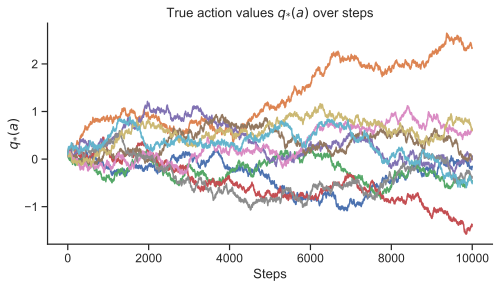

In [16]:
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.set_title(r'True action values $q_{*}(a)$ over steps')
ax.plot(action_values_seq.T);
ax.set_xlabel('Steps')
ax.set_ylabel(r'$q_{*}(a)$')
sns.despine()

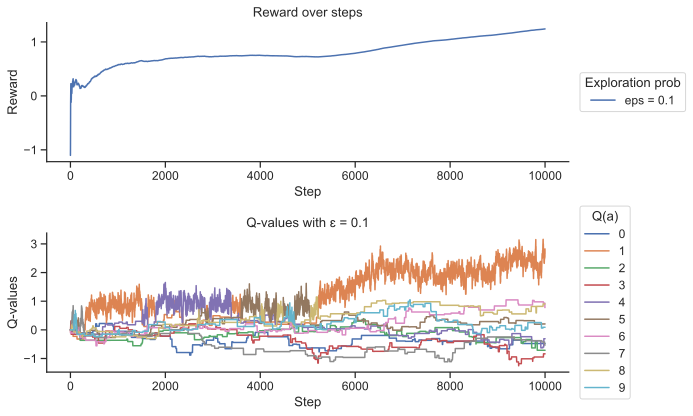

In [17]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(cummean(rewards_seq), label=f'eps = {epsilon}',)
axs[0].set_title('Reward over steps')
axs[0].set_ylabel('Reward')
axs[0].set_xlabel('Step')
axs[0].legend(title='Exploration prob', loc='center left', bbox_to_anchor=(1.01, .5),)

axs[1].set_title(f'Q-values with ɛ = {eps_params[2]}')
pd.DataFrame(q_values).transpose().plot(ax=axs[1])
axs[1].legend(loc='center left', bbox_to_anchor=(1.01, .5), title='Q(a)')
axs[1].set_ylabel('Q-values')
axs[1].set_xlabel('Step')
plt.tight_layout()
sns.despine()

### 2.7 Upper-Confidence-Bound Action Selection

---

What if we select actions according to the UCB
\begin{align}
A_t \equiv \underset{a}{\text{argmax}} \left[ \, Q_t(a) c \sqrt{\frac{\ln t}{N_t(a)}} \, \right]
\end{align}



In [18]:
# Always set the seed
SEED = 31337
np.random.seed(SEED)

# Number of bandits
num_bandits = 10

# Get the "true" action values
action_values = np.sort(np.random.normal(loc=0, scale=1, size=num_bandits))
print(f"action values: [{'; '.join([f'{val:.2f}' for val in action_values])}]")

# Parameters
epsilon = 0.1 
num_steps = 10_00
alpha = None
c_explore = 2

action values: [-1.62; -1.02; -0.84; -0.80; -0.54; -0.04; 0.15; 0.27; 0.67; 0.70]


In [19]:
# Initialize
q_values_ucb = np.zeros(shape=(num_bandits, num_steps))
action_counts_ucb = np.zeros((num_bandits))
rewards_seq_ucb = np.zeros((num_steps))
action_values_seq_ucb = np.zeros((len(action_values), num_steps))

for step in range(num_steps):

    # Choose an action with UCB method
    action = (
        np.argmax(q_values_ucb[:, step] + c_explore * np.sqrt(np.log(step + 1) / action_counts_ucb.clip(1))
        )
    )

    # Increment action visits
    action_counts_ucb[action] += 1

    # Obtain and store reward
    reward = np.random.normal(loc=action_values[action], scale=1)
    rewards_seq_ucb[step] = reward

    step_size = 1 / action_counts_ucb[action] if alpha is None else alpha

    # Update Q-value for action taken
    if step + 1 < num_steps:
        q_values_ucb[action, step + 1] = q_values_ucb[action, step] + step_size * (reward - q_values_ucb[action, step])

        # Q-value of the other actions remain the same
        actions_not_taken = [act for act in range(num_bandits) if act != action]
        q_values_ucb[actions_not_taken, step + 1] = q_values_ucb[actions_not_taken, step]

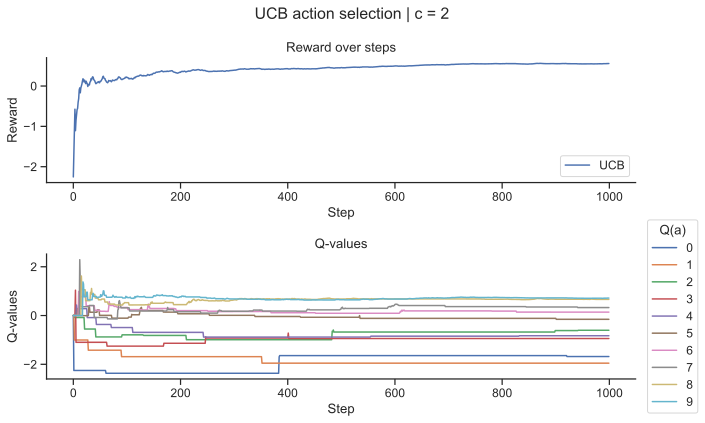

In [20]:
fig, axs = plt.subplots(2, 1)

fig.suptitle(f'UCB action selection | c = {c_explore}')
axs[0].plot(cummean(rewards_seq_ucb), label='UCB')
axs[0].set_title('Reward over steps')
axs[0].set_ylabel('Reward')
axs[0].set_xlabel('Step')
axs[0].legend()

axs[1].set_title(f'Q-values')
pd.DataFrame(q_values_ucb).transpose().plot(ax=axs[1])
axs[1].legend(loc='center left', bbox_to_anchor=(1.01, .5), title='Q(a)')
axs[1].set_ylabel('Q-values')
axs[1].set_xlabel('Step')
plt.tight_layout()
sns.despine()